# Utils

Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix, 
    mean_squared_error, 
    r2_score,
    roc_curve
)

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Paths
path_labels = '/kaggle/input/fcmaps-metadata/labels.csv'
path_fcmaps = '/kaggle/input/fcmaps-processed'                   
path_fcmaps_augmented = '/kaggle/input/fcmaps-augmented-processed/FCmaps_augmented_processed'

# Load labels
df_labels = pd.read_csv(path_labels)

# Temporary:
to_exclude = ['3_S_5003', '4_S_5003', '4_S_5005', '4_S_5007', '4_S_5008']
df_labels = df_labels[~df_labels['ID'].isin(to_exclude)].reset_index(drop=True)

# Dataset

In [3]:
class FCDataset(Dataset):
    def __init__(self, data_dir, df_labels, label_column, task, transform=None):       
        self.data_dir = data_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.label_column = label_column
        self.task = task
        self.transform = transform
    
        # Dictionary for mapping strings to indices if labels are not numbers
        if not pd.api.types.is_numeric_dtype(self.df_labels[self.label_column]):
            unique_labels = sorted(self.df_labels[self.label_column].unique())
            self.label_mapping = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label_mapping = None
            
        self.samples = []

        # Loop over each row of the dataframe
        for _, row in self.df_labels.iterrows():
            subj_id = row['ID']
            label = self.label_mapping[row[self.label_column]] if self.task == 'classification' else float(row[self.label_column])
            file_path = os.path.join(data_dir, f"{subj_id}.processed.npy")
            if os.path.exists(file_path):
                self.samples.append((file_path, label))
            else:
                print(f"Missing file: {file_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        
        # Load and reshape the volume: (1, 91, 109, 91)
        volume = np.load(file_path)
        volume = np.expand_dims(volume, axis=0)  

        # Covert volume into a tensor
        x = torch.tensor(volume, dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.long if self.task == 'classification' else torch.float32)
        if self.transform:
            x = self.transform(x)

        return x, y

In [4]:
class AugmentedFCDataset(Dataset):
    def __init__(self, data_dir, df_labels, label_column, task, transform=None):
        
        self.data_dir = data_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.label_column = label_column
        self.task = task
        self.transform = transform

        # Mapping
        if not pd.api.types.is_numeric_dtype(self.df_labels[self.label_column]):
            unique_labels = sorted(self.df_labels[self.label_column].unique())
            self.label_mapping = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label_mapping = None
            
        self.samples = []

        for _, row in self.df_labels.iterrows():
            subj_id = row['ID']
            label = self.label_mapping[row[self.label_column]] if self.task == 'classification' else float(row[self.label_column])
            subject_folder = os.path.join(data_dir, subj_id)
            if os.path.isdir(subject_folder):
                for file in os.listdir(subject_folder):
                    if file.endswith('.npy'):
                        file_path = os.path.join(subject_folder, file)
                        self.samples.append((file_path, label))
            else:
                print(f"Warning: missing augmented folder for subject {subj_id}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load and reshape the volume: (1, 91, 109, 91)
        volume = np.load(file_path)
        volume = np.expand_dims(volume, axis=0)

        x = torch.tensor(volume, dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.long if self.task == 'classification' else torch.float32)
        if self.transform:
            x = self.transform(x)

        return x, y

# CNN Models

## Network

In [5]:
class SimpleCNN3D(nn.Module):
    def __init__(self, n_classes):
        super(SimpleCNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.AdaptiveAvgPool3d(1)

        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


class ResNet3D(nn.Module):
    def __init__(self, n_classes):
        super(ResNet3D, self).__init__()
        self.model = r3d_18(weights=None)
        self.model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3), bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

# Data

In [6]:
# PARAMETERS DICTIONARY

params = {
    'batch_size': 16,
    'epochs': 20,
    'lr': 5e-4,
    'weight_decay': 0.00001,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'task': 'classification', 
    'n_folds': 10,  
    'network': 'simplecnn',  # 'resnet' or 'simplecnn'
    'group1': 'ADNI',
    'group2': 'PSP',
    'test_size': 0.2,
    'val_size': 0.2,
    'label_column': 'Group',
    'use_cross_val': True,
    'checkpoints_dir':"/kaggle/working/runs"
}

# Loss function and number of classes
if params['task'] == 'classification':
    params['criterion'] = nn.CrossEntropyLoss()
    params['n_classes'] = 2
else:
    params['criterion'] = nn.MSELoss()
    params['n_classes'] = 1


# Output directory for runs
os.makedirs(params['checkpoints_dir'], exist_ok=True)

Load some files for example

In [7]:
img3D = np.load('/kaggle/input/fcmaps-processed/002_S_4654.processed.npy')

print(img3D.shape)
print(img3D.dtype)

(91, 109, 91)
float32


## Pairwise classification

- ADNI + CBS = 116 
- CBS + PSP = 105 
- ADNI + PSP = 133

In [8]:
df_pair = df_labels[df_labels['Group'].isin([params['group1'], params['group2']])].reset_index(drop=True)

In [9]:
print(df_pair.shape)
print("\nSubjects per group:")
print(df_pair['Group'].value_counts())

(129, 5)

Subjects per group:
Group
ADNI    72
PSP     57
Name: count, dtype: int64


## Splitting

In [10]:
# ----------- SPLIT TRAIN/TEST ------------
subjects = df_pair['ID'].values
labels = df_pair[params['label_column']].values

train_subj, test_subj = train_test_split(
    subjects,
    stratify=labels,
    test_size=params['test_size'],
    random_state=42
)

train_df = df_pair[df_pair['ID'].isin(train_subj)].reset_index(drop=True)
df_test = df_pair[df_pair['ID'].isin(test_subj)].reset_index(drop=True)


# ----------- SPLIT TRAIN/VALIDATION  ------------
if params['use_cross_val']:
    df_train = train_df
    print("Cross-validation selected: Validation sets will be created inside each fold.")
else:
    subjects_train = train_df['ID'].values
    labels_train = train_df[params['label_column']].values

    train_subj, val_subj = train_test_split(
        subjects_train,
        stratify=labels_train,
        test_size=params['val_size'],
        random_state=42
    )

    df_train = train_df[train_df['ID'].isin(train_subj)].reset_index(drop=True)
    df_val = train_df[train_df['ID'].isin(val_subj)].reset_index(drop=True)

Cross-validation selected: Validation sets will be created inside each fold.


Check balance

In [11]:
print("Train set label distribution:")
print("Total size of the training set: ", df_train.shape[0])
print(df_train['Group'].value_counts())

if not params['use_cross_val']:
    print("\nValidation set label distribution:")
    print("Total size of the validation set: ", df_val.shape[0])
    print(df_val['Group'].value_counts())

print("\nTest set label distribution:")
print("Total size of the testing set: ", df_test.shape[0])
print(df_test['Group'].value_counts())

Train set label distribution:
Total size of the training set:  103
Group
ADNI    57
PSP     46
Name: count, dtype: int64

Test set label distribution:
Total size of the testing set:  26
Group
ADNI    15
PSP     11
Name: count, dtype: int64


Example of augmentation

In [12]:
train_dataset = AugmentedFCDataset(path_fcmaps_augmented, train_df, params['label_column'], params['task'])

In [13]:
print("Shape before augmentation: ", train_df.shape )
print("Shape after augmentation: ", len(train_dataset) )

Shape before augmentation:  (103, 5)
Shape after augmentation:  1030


# Training and validation

## Train, Validaiton and Evaluation Loop

Training function

In [14]:
def train(train_loader, model, criterion, optimizer, device):
    # Enable training mode
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_batch)

        # Compute loss
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    return train_loss

Validation function

In [15]:
def validate(val_loader, model, criterion, device, task):
    # Set model to evaluation mode
    model.eval()
    running_loss = 0.0
    correct = 0

    # Disable gradient computation
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            running_loss += loss.item() * x_val.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)
    return val_loss, val_accuracy

Evaluation function (to get predictions)

In [16]:
def evaluate(model, loader, task, device):
    model.eval()
    true_labels, pred_labels = [], []

    # Disable gradient computation
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            # Convert output to prediction
            if task == 'classification':
                preds = torch.argmax(outputs, dim=1)  
            else:
                preds = outputs.squeeze()  

            # Store true and predicted values
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(pred_labels)

## Potting

In [17]:
def plot_losses_and_accuracy(train_losses, val_losses, val_accuracies):
    """
    Plot Train Loss, Validation Loss and Validation Accuracy over epochs.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o', color='blue')
    plt.plot(val_losses, label='Validation Loss', marker='s', color='orange')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='^', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Loss, Validation Loss and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_losses_only(train_losses, val_losses):
    """
    Plot Train and Validation Loss only.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o', color='blue')
    plt.plot(val_losses, label='Validation Loss', marker='s', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Training without cross validation

In [18]:
def train_validate_model(df_train, df_val, params):
    # Create Datasets
    train_dataset = AugmentedFCDataset(path_fcmaps_augmented, df_train, params['label_column'], params['task'])
    val_dataset = FCDataset(path_fcmaps, df_val, params['label_column'], params['task'])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Model
    if params['network'] == 'resnet':
        model = ResNet3D(n_classes=params['n_classes']).to(params['device'])
    elif params['network'] == 'simplecnn':
        model = SimpleCNN3D(n_classes=params['n_classes']).to(params['device'])
    else:
        raise ValueError("Invalid network specified in params")
        
    optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = params['criterion']

    # Variables
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_accuracy = -float('inf')
    best_epoch = -1
    best_model_path = None

    # Loop over epochs
    for epoch in range(params['epochs']):
        train_loss = train(train_loader, model, criterion, optimizer, params['device'])
        val_loss, val_accuracy = validate(val_loader, model, criterion, params['device'], params['task'])

        print(f"Epoch {epoch+1}/{params['epochs']} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save best model with group names in filename
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_epoch = epoch + 1  
            best_model_path = os.path.join(checkpoint_dir,f'best_model_{params["group1"]}_vs_{params["group2"]}_epoch{best_epoch}.pt')
            torch.save(model.state_dict(), best_model_path)

    print("\nTraining completed.")
    print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_accuracy:.4f}")

    # Plot
    plot_losses_and_accuracy(train_losses, val_losses, val_accuracies)
    plot_losses_only(train_losses, val_losses)

    return best_model_path

## Cross-Validation

In [19]:
def train_model_kfold(df_train, path_fcmaps_augmented, path_fcmaps, params):
    # For k-fold cross-validation
    skf = StratifiedKFold(n_splits=params['n_folds'], shuffle=True, random_state=42)
    
    # Subjects and correspondent labels 
    subjects = df_train['ID'].values
    labels = df_train[params['label_column']].values
    
    all_train_losses = []
    all_val_losses = []
    all_val_accuracies = []
    best_model_paths = []

    # Loop over the k-fold
    for fold, (train_idx, val_idx) in enumerate(skf.split(subjects, labels)):
        print(f"\n--- Fold {fold+1}/{params['n_folds']} ---")

        # Subjects for the current fold
        df_train_fold = df_train[df_train['ID'].isin(subjects[train_idx])].reset_index(drop=True)
        df_val_fold = df_train[df_train['ID'].isin(subjects[val_idx])].reset_index(drop=True)
    
        # Create Datasets
        train_dataset = AugmentedFCDataset(path_fcmaps_augmented, df_train_fold, params['label_column'], params['task'])
        val_dataset = FCDataset(path_fcmaps, df_val_fold, params['label_column'], params['task'])

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
        
        # Create the model and optimizer 
        if params['network'] == 'resnet':
            model = ResNet3D(n_classes=params['n_classes']).to(params['device'])
        elif params['network'] == 'simplecnn':
            model = SimpleCNN3D(n_classes=params['n_classes']).to(params['device'])
        else:
            raise ValueError("Unknown network type specified in", params['network'])

        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    
        # Variables
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_accuracy = -float('inf')
        best_epoch = -1
        best_model_path = None

        # Loop over epochs
        for epoch in range(params['epochs']):
            train_loss = train(train_loader, model, params['criterion'], optimizer, params['device'])
            val_loss, val_accuracy = validate(val_loader, model, params['criterion'], params['device'], params['task'])

            print(f"Epoch {epoch+1}/{params['epochs']} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            checkpoint_name = f"best_model_fold{fold+1}_epoch{epoch+1}_{params['group1']}_vs_{params['group2']}.pt"
            full_path = os.path.join(params['checkpoints_dir'], checkpoint_name)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_epoch = epoch + 1
                best_model_path = full_path
                torch.save({
                    'epoch': best_epoch,
                    'state_dict': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'val_accuracy': best_accuracy,
                    'val_loss': val_loss
                }, best_model_path)
                

        # Log the best model for this fold
        if best_model_path:
            best_model_paths.append({
                'fold': fold+1,
                'model_path': best_model_path,
                'best_accuracy': best_accuracy,
                'best_epoch': best_epoch
            })

        # Save for plotting
        plot_losses_and_accuracy(train_losses, val_losses, val_accuracies)
        plot_losses_only(train_losses, val_losses)

    return best_model_paths

# Evaluation

In [20]:
def select_best_model_among_folds(best_model_paths):
    """
    Selects the fold with the highest validation accuracy.
    Returns the dictionary with model_path and metrics.
    """
    best_entry = max(best_model_paths, key=lambda x: x['best_accuracy'])

    print("\n--- Best fold summary ---")
    print(f"Fold number : {best_entry['fold']}")
    print(f"Best Epoch  : {best_entry['best_epoch']}")
    print(f"Best Accuracy: {best_entry['best_accuracy']:.4f}")
    print(f"Model path  : {best_entry['model_path']}\n")

    return best_entry

In [21]:
def test_model(df_test, model_path, path_fcmaps, params):
    test_dataset = FCDataset(path_fcmaps, df_test, params['label_column'], params['task'])
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    if params['network'] == 'resnet':
        model = ResNet3D(n_classes=params['n_classes']).to(params['device'])
    elif params['network'] == 'simplecnn':
        model = SimpleCNN3D(n_classes=params['n_classes']).to(params['device'])
    else:
        raise ValueError("Unknown network type specified in params['network']")

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=params['device'], weights_only=True)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    # Predicting
    y_true, y_pred = evaluate(model, test_loader, params['task'], params['device'])

    return y_true, y_pred

In [22]:
def compute_performance_and_plots(y_true, y_pred, params):
    # --- METRICS ---
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    try:
        roc_auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        roc_auc = float('nan')  # AUC not computable if only 1 class present

    print("\n--- Test Metrics ---")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {roc_auc:.4f}")

    # --- CONFUSION MATRIX ---
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=[params['group1'], params['group2']],
                yticklabels=[params['group1'], params['group2']])
    plt.title("Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- ROC CURVE ---
    if params['task'] == 'classification':
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Main

Training


--- Fold 1/10 ---
Epoch 1/20 | Train Loss: 0.6950 | Val Loss: 0.6908 | Val Accuracy: 0.5455
Epoch 2/20 | Train Loss: 0.6880 | Val Loss: 0.7170 | Val Accuracy: 0.5455
Epoch 3/20 | Train Loss: 0.6809 | Val Loss: 0.6637 | Val Accuracy: 0.6364
Epoch 4/20 | Train Loss: 0.6740 | Val Loss: 0.6652 | Val Accuracy: 0.5455
Epoch 5/20 | Train Loss: 0.6716 | Val Loss: 0.6245 | Val Accuracy: 0.7273
Epoch 6/20 | Train Loss: 0.6564 | Val Loss: 0.6732 | Val Accuracy: 0.6364
Epoch 7/20 | Train Loss: 0.6492 | Val Loss: 1.0915 | Val Accuracy: 0.4545
Epoch 8/20 | Train Loss: 0.6373 | Val Loss: 0.6668 | Val Accuracy: 0.5455
Epoch 9/20 | Train Loss: 0.6180 | Val Loss: 1.3031 | Val Accuracy: 0.4545
Epoch 10/20 | Train Loss: 0.6124 | Val Loss: 0.9280 | Val Accuracy: 0.4545
Epoch 11/20 | Train Loss: 0.6189 | Val Loss: 0.8400 | Val Accuracy: 0.5455
Epoch 12/20 | Train Loss: 0.6161 | Val Loss: 0.6470 | Val Accuracy: 0.5455
Epoch 13/20 | Train Loss: 0.5994 | Val Loss: 0.9028 | Val Accuracy: 0.4545
Epoch 14/20 | T

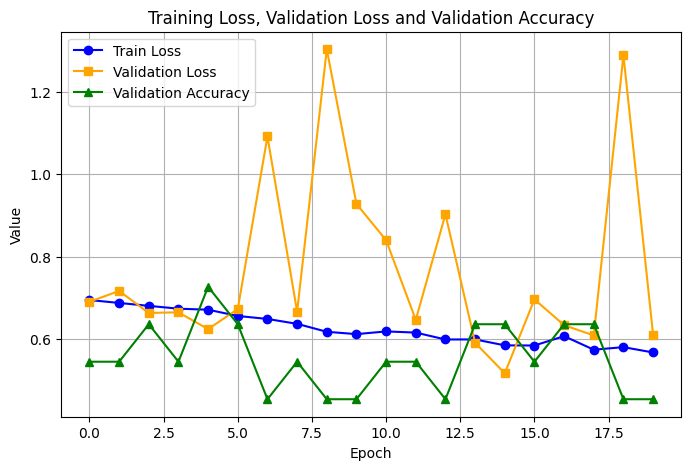

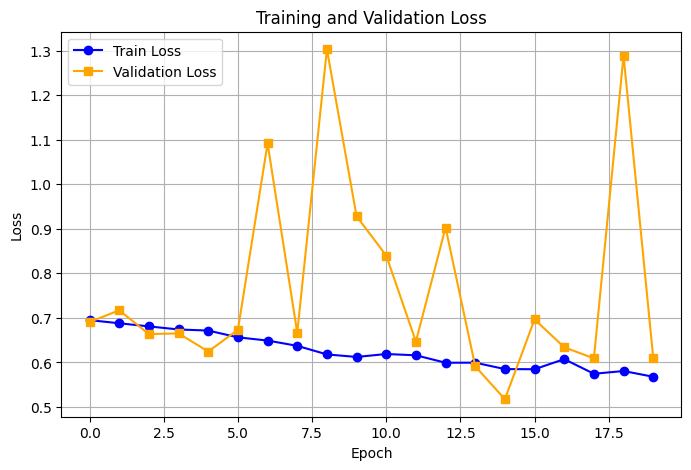


--- Fold 2/10 ---
Epoch 1/20 | Train Loss: 0.6763 | Val Loss: 0.7020 | Val Accuracy: 0.5455
Epoch 2/20 | Train Loss: 0.6610 | Val Loss: 0.7600 | Val Accuracy: 0.5455
Epoch 3/20 | Train Loss: 0.6456 | Val Loss: 0.9407 | Val Accuracy: 0.4545
Epoch 4/20 | Train Loss: 0.6549 | Val Loss: 0.9446 | Val Accuracy: 0.5455
Epoch 5/20 | Train Loss: 0.6355 | Val Loss: 0.9545 | Val Accuracy: 0.5455
Epoch 6/20 | Train Loss: 0.6333 | Val Loss: 0.8646 | Val Accuracy: 0.4545
Epoch 7/20 | Train Loss: 0.6283 | Val Loss: 1.2652 | Val Accuracy: 0.4545
Epoch 8/20 | Train Loss: 0.6130 | Val Loss: 1.0305 | Val Accuracy: 0.4545
Epoch 9/20 | Train Loss: 0.6294 | Val Loss: 0.7967 | Val Accuracy: 0.5455
Epoch 10/20 | Train Loss: 0.6183 | Val Loss: 0.6318 | Val Accuracy: 0.5455
Epoch 11/20 | Train Loss: 0.6156 | Val Loss: 1.0696 | Val Accuracy: 0.5455
Epoch 12/20 | Train Loss: 0.6057 | Val Loss: 0.9160 | Val Accuracy: 0.5455
Epoch 13/20 | Train Loss: 0.5912 | Val Loss: 0.9767 | Val Accuracy: 0.5455
Epoch 14/20 | T

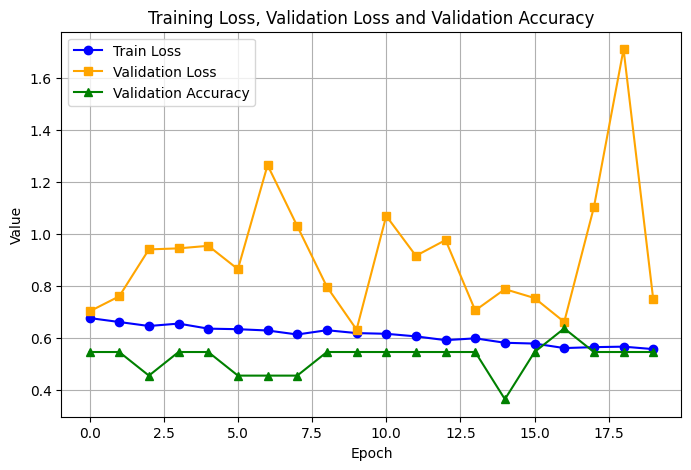

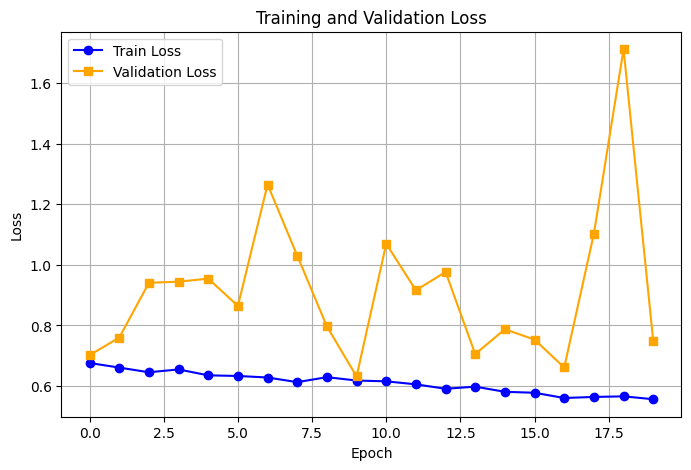


--- Fold 3/10 ---
Epoch 1/20 | Train Loss: 0.6954 | Val Loss: 0.6829 | Val Accuracy: 0.5455
Epoch 2/20 | Train Loss: 0.6874 | Val Loss: 0.6920 | Val Accuracy: 0.5455
Epoch 3/20 | Train Loss: 0.6830 | Val Loss: 0.6459 | Val Accuracy: 0.6364
Epoch 4/20 | Train Loss: 0.6864 | Val Loss: 0.6756 | Val Accuracy: 0.5455
Epoch 5/20 | Train Loss: 0.6763 | Val Loss: 0.8001 | Val Accuracy: 0.5455
Epoch 6/20 | Train Loss: 0.6643 | Val Loss: 0.6066 | Val Accuracy: 0.7273
Epoch 7/20 | Train Loss: 0.6676 | Val Loss: 0.6038 | Val Accuracy: 1.0000
Epoch 8/20 | Train Loss: 0.6725 | Val Loss: 0.6188 | Val Accuracy: 0.7273
Epoch 9/20 | Train Loss: 0.6583 | Val Loss: 0.5958 | Val Accuracy: 0.6364
Epoch 10/20 | Train Loss: 0.6545 | Val Loss: 0.6360 | Val Accuracy: 0.4545
Epoch 11/20 | Train Loss: 0.6676 | Val Loss: 0.6101 | Val Accuracy: 0.8182
Epoch 12/20 | Train Loss: 0.6547 | Val Loss: 0.5824 | Val Accuracy: 0.8182
Epoch 13/20 | Train Loss: 0.6574 | Val Loss: 0.6063 | Val Accuracy: 0.8182
Epoch 14/20 | T

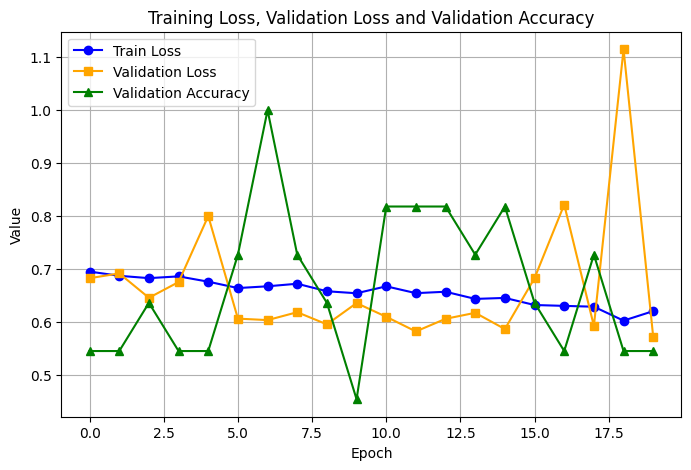

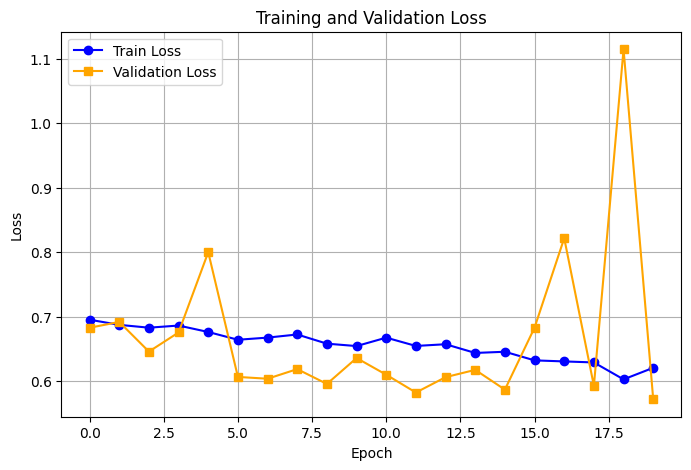


--- Fold 4/10 ---
Epoch 1/20 | Train Loss: 0.6986 | Val Loss: 0.6874 | Val Accuracy: 0.6000
Epoch 2/20 | Train Loss: 0.6891 | Val Loss: 0.6822 | Val Accuracy: 0.6000
Epoch 3/20 | Train Loss: 0.6742 | Val Loss: 0.6759 | Val Accuracy: 0.6000
Epoch 4/20 | Train Loss: 0.6718 | Val Loss: 0.6575 | Val Accuracy: 0.6000
Epoch 5/20 | Train Loss: 0.6636 | Val Loss: 0.6354 | Val Accuracy: 0.7000
Epoch 6/20 | Train Loss: 0.6635 | Val Loss: 0.7138 | Val Accuracy: 0.6000
Epoch 7/20 | Train Loss: 0.6657 | Val Loss: 0.6217 | Val Accuracy: 0.7000
Epoch 8/20 | Train Loss: 0.6506 | Val Loss: 0.6142 | Val Accuracy: 0.6000
Epoch 9/20 | Train Loss: 0.6569 | Val Loss: 0.6579 | Val Accuracy: 0.7000
Epoch 10/20 | Train Loss: 0.6502 | Val Loss: 0.5673 | Val Accuracy: 0.7000
Epoch 11/20 | Train Loss: 0.6554 | Val Loss: 0.6480 | Val Accuracy: 0.6000
Epoch 12/20 | Train Loss: 0.6329 | Val Loss: 0.6414 | Val Accuracy: 0.9000
Epoch 13/20 | Train Loss: 0.6261 | Val Loss: 0.6199 | Val Accuracy: 0.7000
Epoch 14/20 | T

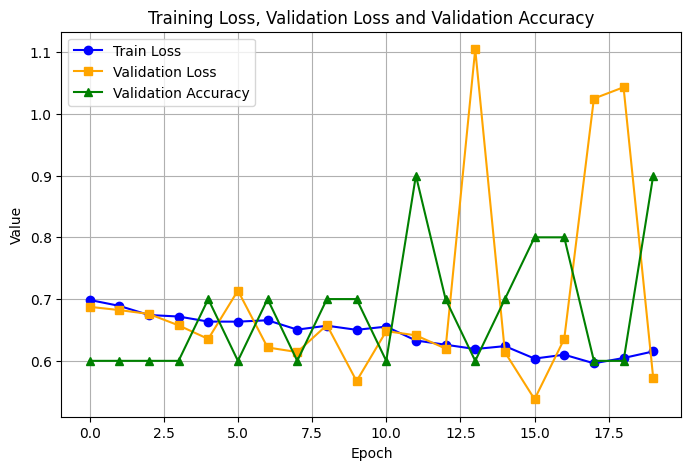

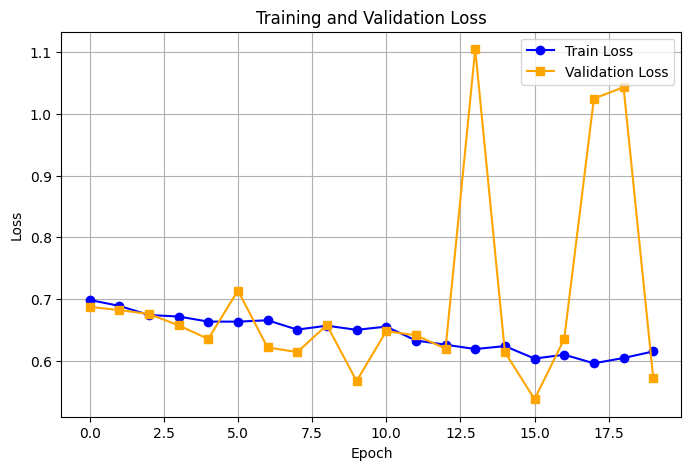


--- Fold 5/10 ---
Epoch 1/20 | Train Loss: 0.6992 | Val Loss: 0.6735 | Val Accuracy: 0.6000
Epoch 2/20 | Train Loss: 0.6790 | Val Loss: 0.6556 | Val Accuracy: 0.6000
Epoch 3/20 | Train Loss: 0.6818 | Val Loss: 0.6381 | Val Accuracy: 0.6000
Epoch 4/20 | Train Loss: 0.6751 | Val Loss: 0.6907 | Val Accuracy: 0.6000
Epoch 5/20 | Train Loss: 0.6702 | Val Loss: 0.6337 | Val Accuracy: 0.7000
Epoch 6/20 | Train Loss: 0.6699 | Val Loss: 0.6311 | Val Accuracy: 0.6000
Epoch 7/20 | Train Loss: 0.6622 | Val Loss: 0.6363 | Val Accuracy: 0.6000
Epoch 8/20 | Train Loss: 0.6500 | Val Loss: 0.8356 | Val Accuracy: 0.6000
Epoch 9/20 | Train Loss: 0.6641 | Val Loss: 0.6748 | Val Accuracy: 0.6000
Epoch 10/20 | Train Loss: 0.6584 | Val Loss: 0.5987 | Val Accuracy: 0.8000
Epoch 11/20 | Train Loss: 0.6459 | Val Loss: 0.6062 | Val Accuracy: 0.8000
Epoch 12/20 | Train Loss: 0.6403 | Val Loss: 0.6444 | Val Accuracy: 0.6000
Epoch 13/20 | Train Loss: 0.6380 | Val Loss: 0.6093 | Val Accuracy: 0.6000
Epoch 14/20 | T

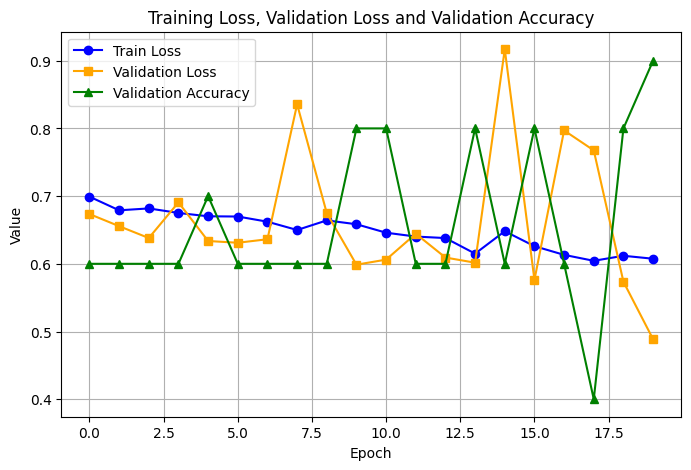

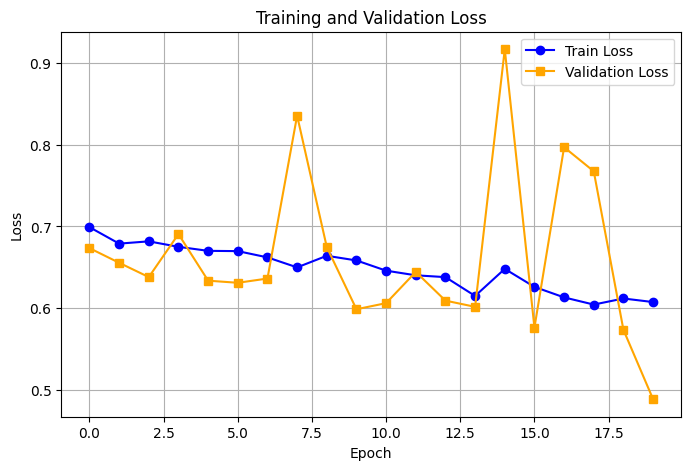


--- Fold 6/10 ---
Epoch 1/20 | Train Loss: 0.6924 | Val Loss: 0.7050 | Val Accuracy: 0.6000
Epoch 2/20 | Train Loss: 0.6803 | Val Loss: 0.8226 | Val Accuracy: 0.6000
Epoch 3/20 | Train Loss: 0.6905 | Val Loss: 0.6571 | Val Accuracy: 0.7000
Epoch 4/20 | Train Loss: 0.6730 | Val Loss: 0.5948 | Val Accuracy: 1.0000
Epoch 5/20 | Train Loss: 0.6730 | Val Loss: 0.6442 | Val Accuracy: 0.7000
Epoch 6/20 | Train Loss: 0.6671 | Val Loss: 1.0782 | Val Accuracy: 0.6000
Epoch 7/20 | Train Loss: 0.6718 | Val Loss: 0.6709 | Val Accuracy: 0.7000
Epoch 8/20 | Train Loss: 0.6640 | Val Loss: 0.7410 | Val Accuracy: 0.7000
Epoch 9/20 | Train Loss: 0.6576 | Val Loss: 0.5446 | Val Accuracy: 0.8000
Epoch 10/20 | Train Loss: 0.6674 | Val Loss: 0.6507 | Val Accuracy: 0.7000
Epoch 11/20 | Train Loss: 0.6480 | Val Loss: 0.7743 | Val Accuracy: 0.7000
Epoch 12/20 | Train Loss: 0.6233 | Val Loss: 0.7209 | Val Accuracy: 0.7000
Epoch 13/20 | Train Loss: 0.6314 | Val Loss: 0.8939 | Val Accuracy: 0.7000
Epoch 14/20 | T

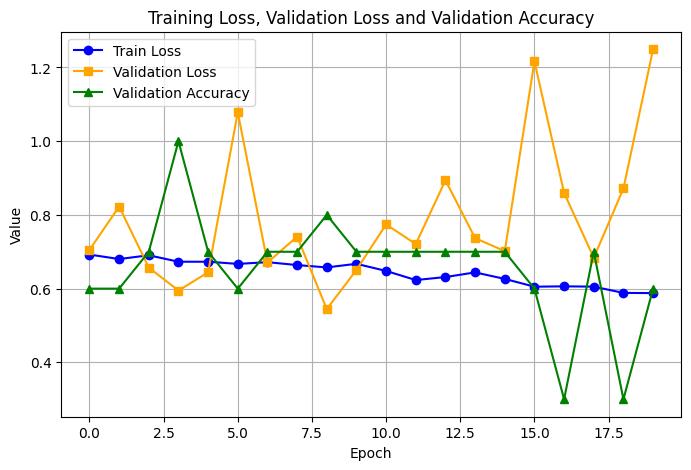

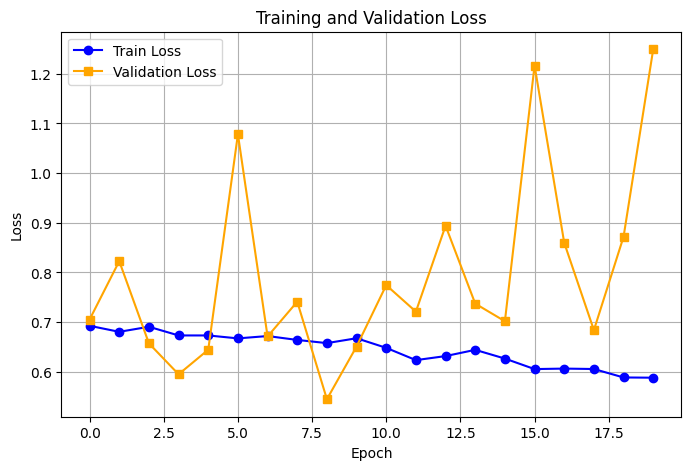


--- Fold 7/10 ---
Epoch 1/20 | Train Loss: 0.6998 | Val Loss: 0.6727 | Val Accuracy: 0.6000
Epoch 2/20 | Train Loss: 0.6816 | Val Loss: 0.6326 | Val Accuracy: 0.6000
Epoch 3/20 | Train Loss: 0.6793 | Val Loss: 0.7015 | Val Accuracy: 0.5000
Epoch 4/20 | Train Loss: 0.6727 | Val Loss: 0.6421 | Val Accuracy: 0.6000
Epoch 5/20 | Train Loss: 0.6712 | Val Loss: 0.6528 | Val Accuracy: 0.7000
Epoch 6/20 | Train Loss: 0.6669 | Val Loss: 0.6669 | Val Accuracy: 0.7000
Epoch 7/20 | Train Loss: 0.6625 | Val Loss: 0.6067 | Val Accuracy: 0.6000
Epoch 8/20 | Train Loss: 0.6492 | Val Loss: 0.6152 | Val Accuracy: 0.6000
Epoch 9/20 | Train Loss: 0.6483 | Val Loss: 0.5877 | Val Accuracy: 0.6000
Epoch 10/20 | Train Loss: 0.6393 | Val Loss: 0.5829 | Val Accuracy: 0.7000
Epoch 11/20 | Train Loss: 0.6396 | Val Loss: 0.7208 | Val Accuracy: 0.6000
Epoch 12/20 | Train Loss: 0.6215 | Val Loss: 0.5766 | Val Accuracy: 0.6000
Epoch 13/20 | Train Loss: 0.6209 | Val Loss: 0.7488 | Val Accuracy: 0.5000
Epoch 14/20 | T

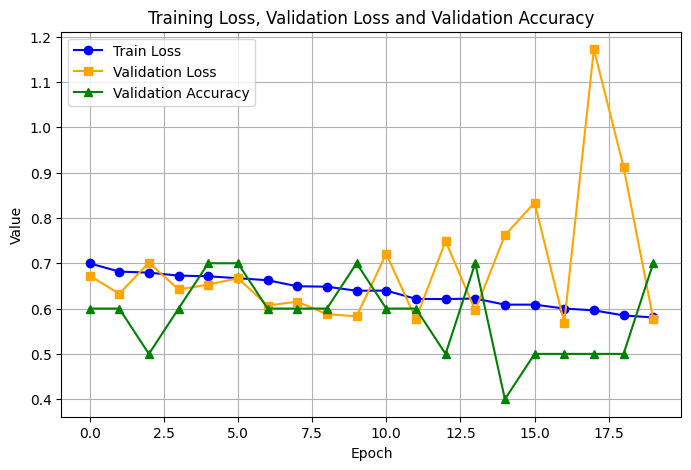

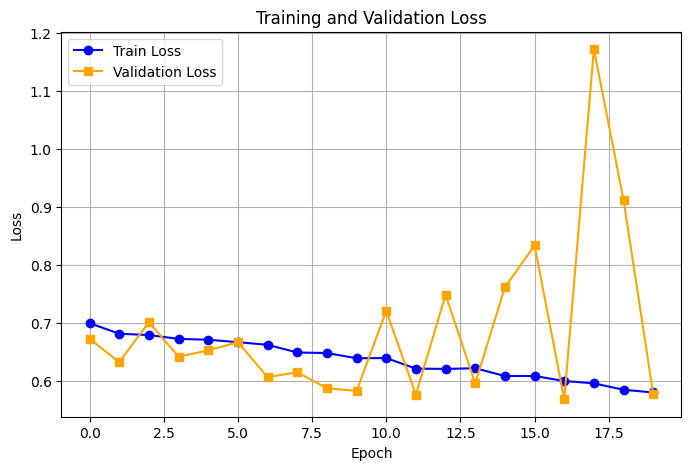


--- Fold 8/10 ---
Epoch 1/20 | Train Loss: 0.6944 | Val Loss: 0.7524 | Val Accuracy: 0.5000
Epoch 2/20 | Train Loss: 0.6807 | Val Loss: 0.6676 | Val Accuracy: 0.5000
Epoch 3/20 | Train Loss: 0.6710 | Val Loss: 0.7193 | Val Accuracy: 0.5000
Epoch 4/20 | Train Loss: 0.6599 | Val Loss: 0.7230 | Val Accuracy: 0.5000
Epoch 5/20 | Train Loss: 0.6690 | Val Loss: 0.7212 | Val Accuracy: 0.4000
Epoch 6/20 | Train Loss: 0.6569 | Val Loss: 0.7553 | Val Accuracy: 0.5000
Epoch 7/20 | Train Loss: 0.6604 | Val Loss: 0.7761 | Val Accuracy: 0.5000
Epoch 8/20 | Train Loss: 0.6614 | Val Loss: 0.6745 | Val Accuracy: 0.6000
Epoch 9/20 | Train Loss: 0.6472 | Val Loss: 0.8025 | Val Accuracy: 0.4000
Epoch 10/20 | Train Loss: 0.6408 | Val Loss: 0.6513 | Val Accuracy: 0.6000
Epoch 11/20 | Train Loss: 0.6381 | Val Loss: 0.8372 | Val Accuracy: 0.5000
Epoch 12/20 | Train Loss: 0.6347 | Val Loss: 0.7904 | Val Accuracy: 0.5000
Epoch 13/20 | Train Loss: 0.6328 | Val Loss: 0.6409 | Val Accuracy: 0.6000
Epoch 14/20 | T

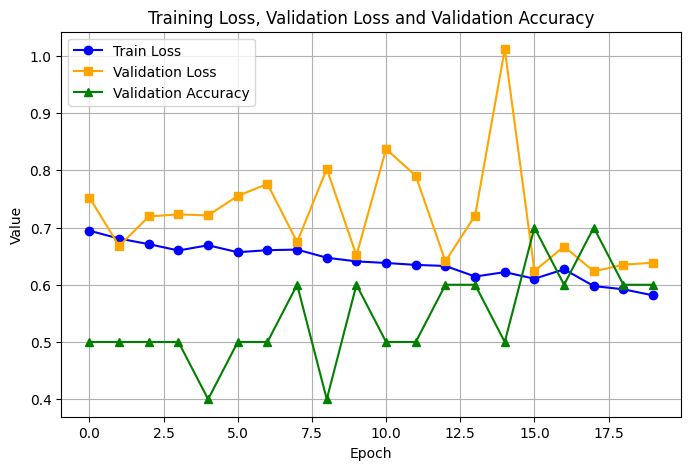

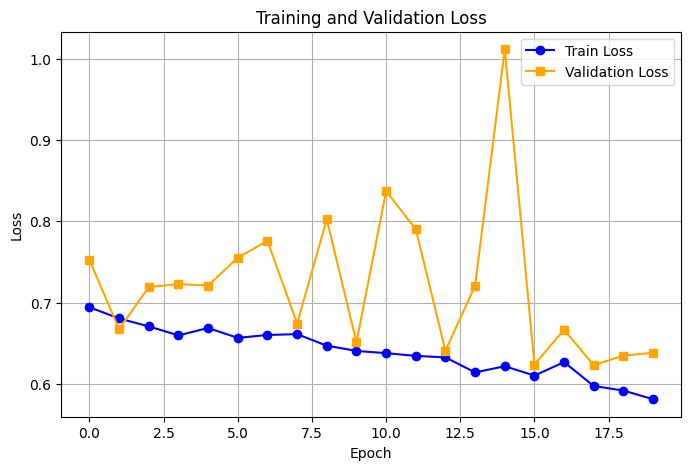


--- Fold 9/10 ---
Epoch 1/20 | Train Loss: 0.6955 | Val Loss: 0.7084 | Val Accuracy: 0.5000
Epoch 2/20 | Train Loss: 0.6784 | Val Loss: 0.7131 | Val Accuracy: 0.5000
Epoch 3/20 | Train Loss: 0.6726 | Val Loss: 0.7159 | Val Accuracy: 0.5000
Epoch 4/20 | Train Loss: 0.6664 | Val Loss: 0.7033 | Val Accuracy: 0.4000
Epoch 5/20 | Train Loss: 0.6724 | Val Loss: 0.7606 | Val Accuracy: 0.5000
Epoch 6/20 | Train Loss: 0.6674 | Val Loss: 0.7079 | Val Accuracy: 0.5000
Epoch 7/20 | Train Loss: 0.6581 | Val Loss: 0.7138 | Val Accuracy: 0.5000
Epoch 8/20 | Train Loss: 0.6506 | Val Loss: 0.7269 | Val Accuracy: 0.5000
Epoch 9/20 | Train Loss: 0.6513 | Val Loss: 0.7817 | Val Accuracy: 0.5000
Epoch 10/20 | Train Loss: 0.6453 | Val Loss: 0.7238 | Val Accuracy: 0.5000
Epoch 11/20 | Train Loss: 0.6318 | Val Loss: 0.9895 | Val Accuracy: 0.5000
Epoch 12/20 | Train Loss: 0.6332 | Val Loss: 0.7233 | Val Accuracy: 0.6000
Epoch 13/20 | Train Loss: 0.6527 | Val Loss: 0.7901 | Val Accuracy: 0.5000
Epoch 14/20 | T

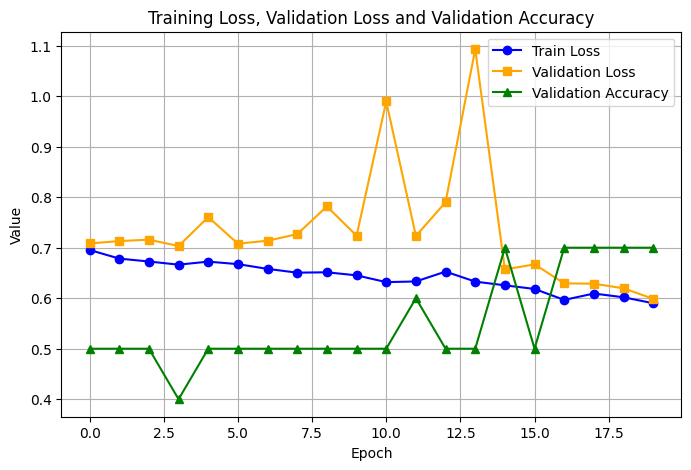

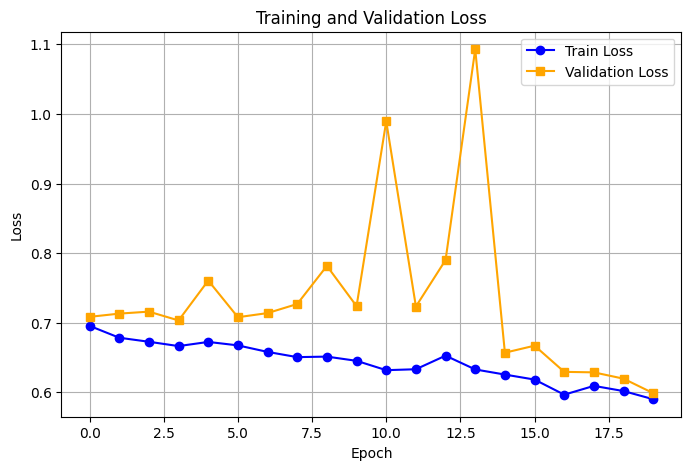


--- Fold 10/10 ---
Epoch 1/20 | Train Loss: 0.6862 | Val Loss: 0.7152 | Val Accuracy: 0.5000
Epoch 2/20 | Train Loss: 0.6832 | Val Loss: 0.7074 | Val Accuracy: 0.5000
Epoch 3/20 | Train Loss: 0.6787 | Val Loss: 0.7502 | Val Accuracy: 0.5000
Epoch 4/20 | Train Loss: 0.6686 | Val Loss: 0.7430 | Val Accuracy: 0.5000
Epoch 5/20 | Train Loss: 0.6685 | Val Loss: 0.6943 | Val Accuracy: 0.4000
Epoch 6/20 | Train Loss: 0.6531 | Val Loss: 0.7406 | Val Accuracy: 0.5000
Epoch 7/20 | Train Loss: 0.6475 | Val Loss: 0.7097 | Val Accuracy: 0.4000
Epoch 8/20 | Train Loss: 0.6472 | Val Loss: 0.7210 | Val Accuracy: 0.6000
Epoch 9/20 | Train Loss: 0.6393 | Val Loss: 0.7453 | Val Accuracy: 0.4000
Epoch 10/20 | Train Loss: 0.6310 | Val Loss: 0.7658 | Val Accuracy: 0.5000
Epoch 11/20 | Train Loss: 0.6356 | Val Loss: 0.7977 | Val Accuracy: 0.4000
Epoch 12/20 | Train Loss: 0.6219 | Val Loss: 1.1229 | Val Accuracy: 0.5000
Epoch 13/20 | Train Loss: 0.6082 | Val Loss: 0.7510 | Val Accuracy: 0.5000
Epoch 14/20 | 

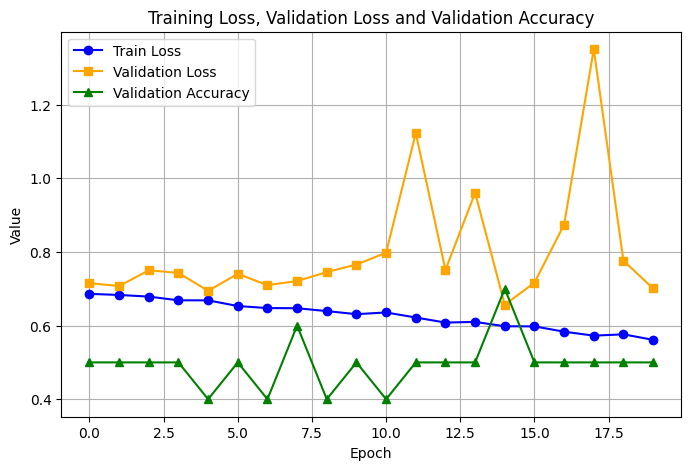

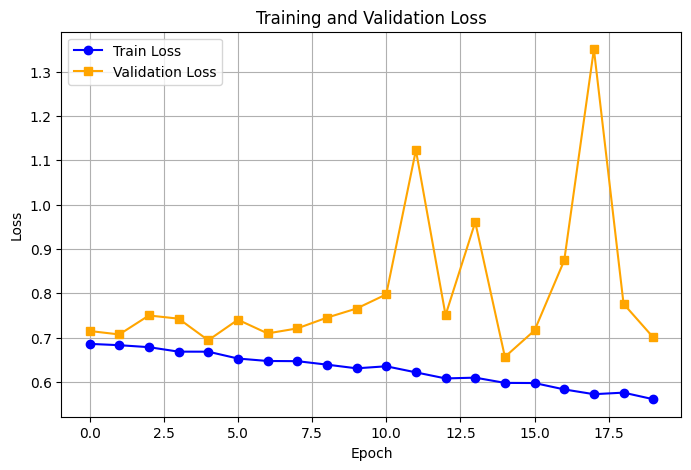


--- Best fold summary ---
Fold number : 3
Best Epoch  : 7
Best Accuracy: 1.0000
Model path  : /kaggle/working/checkpoints/best_model_fold3_epoch7_ADNI_vs_PSP.pt



In [23]:
if params['use_cross_val']:
    # ----- CROSS-VALIDATION -----
    best_model_paths = train_model_kfold(df_train, path_fcmaps_augmented, path_fcmaps, params)
    best_model_entry = select_best_model_among_folds(best_model_paths)
    
    best_model_path = best_model_entry['model_path']

else:
    # ----- NO CROSS-VALIDATION -----
    best_model_path, train_losses, val_losses, val_accuracies = train_model(
        df_train, df_val, path_fcmaps_augmented, path_fcmaps, params
    )

Testing


--- Test Metrics ---
Accuracy : 0.5385
Precision: 0.4000
Recall   : 0.1818
F1-score : 0.2500
ROC AUC  : 0.4909


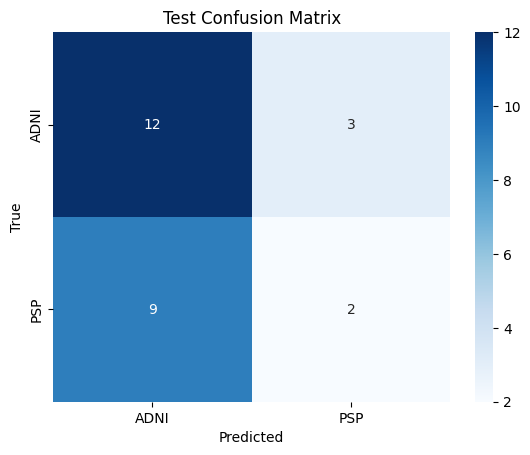

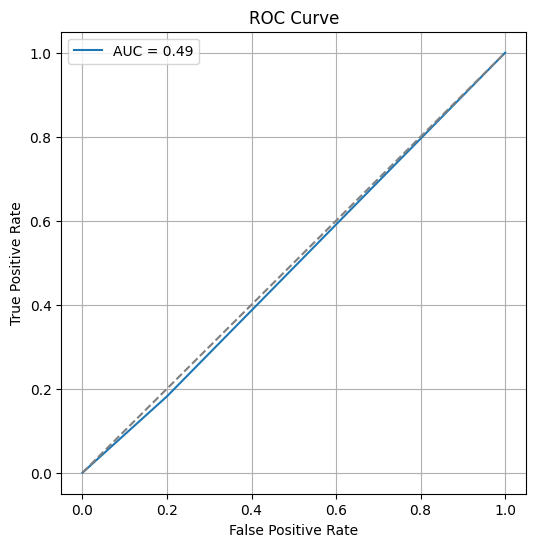

In [24]:
# Eval
y_true, y_pred = test_model(df_test, best_model_path, path_fcmaps, params)

# Metrics
performance = compute_performance_and_plots(y_true, y_pred, params)

# Synthetic data

Synthetic data creation

In [25]:
def create_synthetic_data(n_samples=1500):
    img_shape = (1, 91, 109, 91)
    block_coords = (slice(30,50), slice(40,60), slice(30,50))

    synthetic_data = np.random.normal(0, 1, (n_samples, *img_shape))
    synthetic_labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))

    for i in range(n_samples//2, n_samples):
        synthetic_data[i, 0, block_coords[0], block_coords[1], block_coords[2]] += 5

    return synthetic_data, synthetic_labels

Class Dataset

In [26]:
class SyntheticDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

Train / Validation Split and Dataloaders

In [27]:
def split_and_create_loaders(synthetic_data, synthetic_labels, params):
    X_train, X_test, y_train, y_test = train_test_split(
        synthetic_data, synthetic_labels,
        test_size=params['test_size'],
        stratify=synthetic_labels,
        random_state=42
    )

    if params['use_cross_val']:
        X_train_final = X_train
        y_train_final = y_train
        X_val = None
        y_val = None
    else:
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train,
            test_size=params['val_size'],
            stratify=y_train,
            random_state=42
        )

    return X_train_final, y_train_final, X_val, y_val, X_test, y_test

In [28]:
def run_synthetic_experiment():
    print("Starting synthetic experiment...")

    # Create data
    synthetic_data, synthetic_labels = create_synthetic_data(n_samples=1500)

    # Split & loaders
    X_train_final, y_train_final, X_val, y_val, X_test, y_test = split_and_create_loaders(
        synthetic_data, synthetic_labels, params
    )

    # Train
    if params['use_cross_val']:
        best_model_paths = train_model_kfold_synthetic(X_train_final, y_train_final, params)
        best_model_entry = select_best_model_among_folds(best_model_paths)
        best_model_path = best_model_entry['model_path']
    else:
        best_model_path, train_losses, val_losses, val_accuracies = train_model_synthetic(
            X_train_final, y_train_final, X_val, y_val, params
        )

    # Test
    test_dataset = SyntheticDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    y_true, y_pred = test_model_synthetic(test_loader, best_model_path, params)

    # Performance
    performance = compute_performance_and_plots(y_true, y_pred, params)

    print("Synthetic experiment completed.")
    return performance

In [29]:
#performance = run_synthetic_experiment()